In [1]:
import pickle
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR

from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score

import matplotlib.pyplot as plt
import cv2

from src.utils.feats import load_gei

In [2]:
datapath = "../data/feats/database24_gei_480x640.pkl"
X, y = load_gei(datapath, dim=(64,48), crop_person=True)

In [3]:
model = RandomForestClassifier(n_estimators=150, max_depth=None, random_state=0, criterion='gini')
cv = KFold(n_splits=3, random_state=42, shuffle=True)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)

In [4]:
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f'Mean ACC: {100*np.mean(scores):.5f} +/- {100*np.std(scores):.5f}' )

Mean ACC: 83.91581 +/- 1.77663


# Here we going through a tutorial, nothing to do with the paper yet

# SMOTE for Balancing Data

In [5]:
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

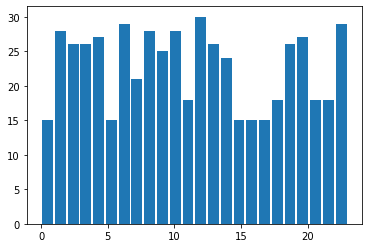

In [6]:
plt.hist(y, bins=24, rwidth=0.85)
plt.show()

In [7]:
# transform the dataset
oversample = SMOTE(random_state=0)
X_balanced, y_balanced = oversample.fit_resample(X, y)

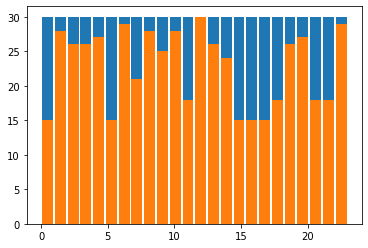

In [8]:
plt.hist(y_balanced, bins=24, rwidth=0.85)
plt.hist(y, bins=24, rwidth=0.85)
plt.show()

# SMOTE for classification

In [9]:
# define pipeline
steps = [('over', SMOTE(random_state=0)), ('model', model)]
pipeline = Pipeline(steps=steps)

In [10]:
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f'Mean ACC: {100*np.mean(scores):.5f} +/- {100*np.std(scores):.5f}' )

Mean ACC: 85.92746 +/- 1.77374


As mentioned in the paper, it is believed that SMOTE performs better when combined with undersampling of the majority class, such as random undersampling.

We can achieve this by simply adding a RandomUnderSampler step to the Pipeline.

In [11]:
over = SMOTE(random_state=0)
under = RandomUnderSampler(random_state=0)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [12]:
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f'Mean ACC: {100*np.mean(scores):.5f} +/- {100*np.std(scores):.5f}' )

Mean ACC: 84.82756 +/- 0.47698


We could explore testing different ratios of the minority class and majority class (e.g. changing the sampling_strategy argument) to see if a further lift in performance is possible.

Another area to explore would be to test different values of the k-nearest neighbors selected in the SMOTE procedure when each new synthetic example is created. The default is k=5, although larger or smaller values will influence the types of examples created, and in turn, may impact the performance of the model.

For example, we could grid search a range of values of k, such as values from 1 to 7, and evaluate the pipeline for each value.

In [13]:
k_values = [1,2,3,4,5,6,7]
for k in k_values:
    X, y = load_gei(datapath, dim=(64,48), crop_person=True)
    # define pipeline
    over = SMOTE(k_neighbors=k, random_state=0)
    under = RandomUnderSampler(random_state=0)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
 
    # evaluate pipeline
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    print(f'> k={k:d}, Mean ACC: {100*np.mean(scores):.5f} +/- {100*np.std(scores):.5f}' )

> k=1, Mean ACC: 84.46026 +/- 0.69387
> k=2, Mean ACC: 82.81891 +/- 1.53087
> k=3, Mean ACC: 84.64541 +/- 0.86074
> k=4, Mean ACC: 85.56316 +/- 2.25889
> k=5, Mean ACC: 84.82756 +/- 0.47698
> k=6, Mean ACC: nan +/- nan
> k=7, Mean ACC: nan +/- nan


# SMOTE With Selective Synthetic Sample Generation

## Borderline-SMOTE


In [14]:
from imblearn.over_sampling import BorderlineSMOTE

In [15]:
# transform the dataset
oversample = BorderlineSMOTE(random_state=0)
X_over, y_over = oversample.fit_resample(X, y)

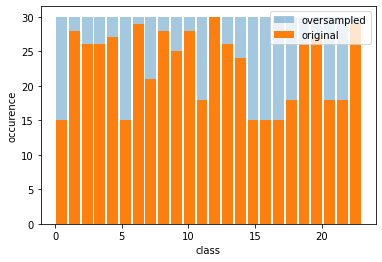

In [16]:
plt.hist(y_over, bins=24, alpha=0.4,rwidth=0.85, label="oversampled")
plt.hist(y, bins=24, alpha=1, rwidth=0.85, label="original")
plt.xlabel("class")
plt.ylabel("occurence")
plt.legend(loc='best')
plt.show()

In [17]:
steps = [('over', BorderlineSMOTE(random_state=0)), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f'Mean ACC: {100*np.mean(scores):.5f} +/- {100*np.std(scores):.5f}' )

Mean ACC: 83.91781 +/- 2.42679


## Borderline-SMOTE SVM

In [18]:
from imblearn.over_sampling import SVMSMOTE

In [19]:
oversample = SVMSMOTE(random_state=0)
X_over, y_over = oversample.fit_resample(X, y)

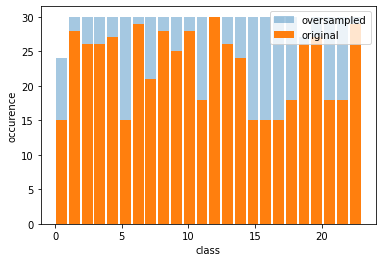

In [20]:
plt.hist(y_over, bins=24, alpha=0.4,rwidth=0.85, label="oversampled")
plt.hist(y, bins=24, alpha=1, rwidth=0.85, label="original")
plt.xlabel("class")
plt.ylabel("occurence")
plt.legend(loc='best')
plt.show()

In [21]:
steps = [('over', SVMSMOTE(random_state=0)), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f'Mean ACC: {100*np.mean(scores):.5f} +/- {100*np.std(scores):.5f}' )

Mean ACC: 83.73066 +/- 1.01483


# Now, lets use smote in optimization pipeline

In [22]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram


from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

from src.utils.results import df_results


In [23]:
dim = (64, 48)
crop_person = True

X, y = load_gei(datapath, dim=dim, crop_person=crop_person) 

In [24]:
# pipeline class is used as estimator to enable
# search over different model types

base_pipe = Pipeline([   
    ('over', SMOTE()),
    ('model', SVC())
])

In [25]:
# ada_search = {
#     'over': Categorical([SMOTE(random_state=0), BorderlineSMOTE(random_state=0), SVMSMOTE(random_state=0)]),    
#     'model': Categorical([AdaBoostClassifier(random_state=0)]),    
#     'model__n_estimators': Integer(1, 400),     
#     'model__learning_rate': Real(1e-6, 1e+0, prior='log-uniform'),
# }

# gdb_search = {
#     'over': Categorical([SMOTE(random_state=0), BorderlineSMOTE(random_state=0), SVMSMOTE(random_state=0)]),    
#     'model': Categorical([GradientBoostingClassifier(max_depth=None, random_state=0)]),    
#     'model__learning_rate': Real(1e-3, 0.5, prior='uniform'),
#     'model__n_estimators': Integer(1, 400),         
#     'model__max_depth': Integer(1, 400),     
# }


knn_search = {
    'over': Categorical([SMOTE(random_state=0), BorderlineSMOTE(random_state=0), SVMSMOTE(random_state=0)]),       
    'model': Categorical([KNeighborsClassifier()]),    
    'model__n_neighbors': Integer(1,6),    
}

rf_search = {
    'over': Categorical([SMOTE(random_state=0), BorderlineSMOTE(random_state=0), SVMSMOTE(random_state=0)]),       
    'model': Categorical([RandomForestClassifier(max_depth=None, random_state=0, criterion='gini')]),    
    'model__n_estimators': Integer(100, 400),    
}

svc_search = {
    'over': Categorical([SMOTE(random_state=0), BorderlineSMOTE(random_state=0), SVMSMOTE(random_state=0)]),          
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}


In [26]:
opt = BayesSearchCV(
    base_pipe,
    # (parameter space, # of evaluations)    
    [(knn_search, 32), (svc_search, 128), (rf_search, 128)],
    cv=cv,
    scoring='accuracy'
)

opt.fit(X, y)

/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/wesley.passos/miniconda3/envs/libras/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:

BayesSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
              estimator=Pipeline(steps=[('over', SMOTE()), ('model', SVC())]),
              scoring='accuracy',
              search_spaces=[({'model': Categorical(categories=(KNeighborsClassifier(),), prior=None),
                               'model__n_neighbors': Integer(low=1, high=6, prior='uniform', transform='identity'),
                               'over': Categorical(categories=(SMOTE(ran...
                               'over': Categorical(categories=(SMOTE(random_state=0), BorderlineSMOTE(random_state=0), SVMSMOTE(random_state=0)), prior=None)},
                              128),
                             ({'model': Categorical(categories=(RandomForestClassifier(random_state=0),), prior=None),
                               'model__n_estimators': Integer(low=100, high=400, prior='uniform', transform='identity'),
                               'over': Categorical(categories=(SMOTE(random_state=0), Bor

In [32]:
df = df_results(opt)
df.to_csv("results_SMOTE.csv")
df[:20]

,model,model__n_neighbors,over,model__C,model__degree,model__gamma,model__kernel,model__n_estimators,mean_test_score,std_test_score,rank
149,"SVC(C=1000000.0, degree=6, gamma=0.00013027014...",NaN,SVMSMOTE(random_state=0),292826.213596,1.0,0.000001,rbf,NaN,0.864717,0.002932,1
152,"SVC(C=1000000.0, degree=6, gamma=0.00013027014...",NaN,SVMSMOTE(random_state=0),981436.697647,5.0,0.000026,rbf,NaN,0.864717,0.002932,1
159,"SVC(C=1000000.0, degree=6, gamma=0.00013027014...",NaN,SVMSMOTE(random_state=0),54473.567787,1.0,0.000001,rbf,NaN,0.864717,0.002932,1
156,"SVC(C=1000000.0, degree=6, gamma=0.00013027014...",NaN,SVMSMOTE(random_state=0),1000000.000000,1.0,0.000021,rbf,NaN,0.864717,0.002932,1
73,"SVC(C=1000000.0, degree=6, gamma=0.00013027014...",NaN,SVMSMOTE(random_state=0),1000000.000000,6.0,0.000130,rbf,NaN,0.864717,0.007166,1
74,"SVC(C=1000000.0, degree=6, gamma=0.00013027014...",NaN,SVMSMOTE(random_state=0),1000000.000000,2.0,0.000146,rbf,NaN,0.864717,0.007166,1
86,"SVC(C=1000000.0, degree=6, gamma=0.00013027014...",NaN,SMOTE(random_state=0),0.285511,2.0,10.000000,linear,NaN,0.862888,0.004786,7
87,"SVC(C=1000000.0, degree=6, gamma=0.00013027014...",NaN,SMOTE(random_state=0),0.283976,2.0,10.000000,linear,NaN,0.862888,0.004786,7
88,"SVC(C=1000000.0, degree=6, gamma=0.00013027014...",NaN,SMOTE(random_state=0),0.282552,2.0,10.000000,linear,NaN,0.862888,0.004786,7
89,"SVC(C=1000000.0, degree=6, gamma=0.00013027014...",NaN,SMOTE(random_state=0),0.281154,2.0,10.000000,linear,NaN,0.862888,0.004786,7
